In [1]:
import numpy as np
from scipy.special import iv
import timeit
import viscid 
import imp
from scipy.linalg import eig
import matplotlib.pyplot as plt

In [13]:
#If you edit viscid while the kernel is running, run this to reload the package
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

In [14]:
args=viscid.args

In [15]:
#Focus on a specific wavenumber corresponding to half the substrate periodicity
args.kx=0
args.ky=args.k2y/2
q=(args.kx**2+args.ky**2)**0.5
omega=(q*np.tanh(q*args.h0)*(args.g+args.sigma*q**2))**0.5
viscid.args.freq=2*omega/(2*np.pi)

In [17]:
args.kx=args.k2y/2
args.dim=1
omega=2*np.pi*args.freq/2
F,G=viscid.viscid_boundary(omega/2,args)

In [19]:
G.shape

(2, 2, 11, 11, 11, 11)

### Dispersion relation for the inviscid problem in Sec. III. The notes Sec. IV describe continuation to the viscid problem starting from the inviscid dispersion, but I haven't been able to do that yet. Instead, below, I continue starting from the instability boundary described in Sec. V, starting with a flat substrate and changing As and ad in turn.

In [5]:
num=50

start=timeit.default_timer()
ks=np.arange(1,num)/num*args.k2y/2
evalssweep1=[]
for k in ks:
    args.ky=k
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep1=evalssweep1+[evals]
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
kxs2=args.k2x/2+np.arange(1,num)/num*((2*args.k2x + args.k1x)/3 - args.k2x/2)
kys2=args.k2y/2+np.arange(1,num)/num*((2*args.k2y + args.k1y)/3 - args.k2y/2)
evalssweep2=[]
for i in range(num-1):
    args.kx=kxs2[i]
    args.ky=kys2[i]
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep2=evalssweep2+[evals]
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
kxs3=np.arange(1,num)/num*((2*args.k2x + args.k1x)/3)
kys3=np.arange(1,num)/num*((2*args.k2y + args.k1y)/3)
evalssweep3=[]
for i in range(num-1):
    args.kx=kxs3[i]
    args.ky=kys3[i]
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep3=evalssweep3+[evals]
stop=timeit.default_timer()
print(stop-start)

0.7766339380000007
0.7361933080000007
0.7566296970000002


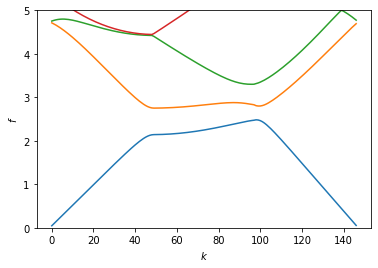

In [6]:
vals1=np.sort(np.abs(np.imag(np.array(evalssweep1)**0.5/(2*np.pi))),axis=1)
vals2=np.sort(np.abs(np.imag(np.array(evalssweep2)**0.5/(2*np.pi))),axis=1)
vals3=np.flip(np.sort(np.abs(np.imag(np.array(evalssweep3)**0.5/(2*np.pi))),axis=1),axis=0)

plt.ylim(0,5)
plt.plot(np.concatenate([vals1,vals2,vals3]))
plt.xlabel('$k$')
plt.ylabel('$f$')           
plt.show()

In [6]:
args.kx=0
args.ky=args.k2y/2

F,G=viscid.inviscid_mat(args)
Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
evals,levecs,revecs=eig(Fflattened,Gflattened,left=True)

ind=np.argmin((-evals)**0.5)+1

print(np.linalg.norm(levecs[:,ind]@Fflattened-evals[ind]*levecs[:,ind]@Gflattened))
print(np.linalg.norm(Fflattened@revecs[:,ind]-evals[ind]*Gflattened@revecs[:,ind]))


v0_inviscid=revecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1)))
w0_inviscid=np.conjugate(levecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1))))

print(np.linalg.norm(np.einsum("mMnN,MN",F[0,0],v0_inviscid)-evals[ind]*np.einsum("mMnN,MN",G[0,0],v0_inviscid)))
print(np.linalg.norm(np.einsum("mMnN,mn",F[0,0],w0_inviscid)-evals[ind]*np.einsum("mMnN,mn",G[0,0],w0_inviscid)))

6.202146000515097e-10
1.0685336807731937e-09
1.0685185190439117e-09
6.202076616741489e-10


In [7]:
np.argmin((-evals)**0.5)+1

63

In [10]:
np.argsort((-evals))[:4]

array([62, 63, 64, 65])

### Viscid instability boundary for flat substrate

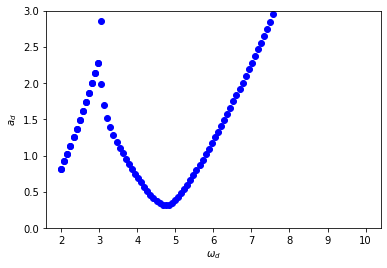

In [8]:
args.kx=0
args.ky=args.k2y/2
omega=2*np.pi*args.freq/2

evalssweep=[]
omegas=np.linspace(2*np.pi*2, 2*np.pi*10, 100)
for omega in omegas:
    viscid.args.freq=omega/(2*np.pi)
    Ftilde_0,Gtilde_0=viscid.viscid_flat_boundary(omega/2,args)
    Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
    Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
    evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)
    evalssweep=evalssweep+[evals]
viscid.args.freq=2*(q*np.tanh(q*args.h0)*(args.g+args.sigma*q**2))**0.5/(2*np.pi)
plt.plot(omegas/(2*np.pi),np.real(evalssweep)/args.g,'bo')
plt.ylim(0,3)
plt.xlabel(r'$\omega_d$')
plt.ylabel('$a_d$')
plt.show()


### Continue the flat viscid instability boundary to the sinusoidal viscid instability boundary, As=0 to As=0.05

In [9]:
from scipy.linalg import solve
from scipy.linalg import LinAlgWarning
import warnings
warnings.filterwarnings("error",category=LinAlgWarning)

start=timeit.default_timer()
viscid.args.freq=2*(q*np.tanh(q*args.h0)*(args.g+args.sigma*q**2))**0.5/(2*np.pi)

omega=2*np.pi*viscid.args.freq/2
Ftilde_0,Gtilde_0=viscid.viscid_flat_mat(omega,qx,qy)
Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)
v0=revecs[:,~np.isinf(evals)][:,-1].reshape((3,(2*args.Nt+1)))
w0=np.conjugate(levecs[:,~np.isinf(evals)][:,-1].reshape((3,(2*args.Nt+1))))
e1=np.linalg.norm(np.einsum("kKlL,KL",Ftilde_0,v0)-evals[~np.isinf(evals)][-1]*np.einsum("kKlL,KL",Gtilde_0,v0))
e2=np.linalg.norm(np.einsum("kKlL,kl",Ftilde_0,w0)-evals[~np.isinf(evals)][-1]*np.einsum("kKlL,kl",Gtilde_0,w0))
print(e1,e2,(np.einsum("kKlL,KL,kl",Ftilde_0,v0,w0)/np.einsum("kKlL,KL,kl",Gtilde_0,v0,w0)))

Ftilde,Gtilde=viscid.viscid_mat2(omega,qx,qy)

v=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
w=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
v[:,:,args.Nx,args.Ny]=v0
w[:,:,args.Nx,args.Ny]=w0

for i in range(10):
    lam=(np.einsum("kKlLmMnN,KLMN,klmn",Ftilde,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",Gtilde,v,w))
    flat=np.transpose(lam*Gtilde-Ftilde,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
    try:
        xi=solve(flat, np.einsum("kKlLmMnN,KLMN",Gtilde,v).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",Gtilde,w).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        v=xi/np.linalg.norm(xi)
        w=zeta/np.linalg.norm(zeta)
    except LinAlgWarning:
        print('convergence')
        lam=(np.einsum("kKlLmMnN,KLMN,klmn",Ftilde,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",Gtilde,v,w))
        e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",Ftilde,v)-lam*np.einsum("kKlLmMnN,KLMN",Gtilde,v))
        e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",Ftilde,w)-lam*np.einsum("kKlLmMnN,klmn",Gtilde,w))
        print(e1,e2,lam,flush=True)
        break

    e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",Ftilde,v)-lam*np.einsum("kKlLmMnN,KLMN",Gtilde,v))
    e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",Ftilde,w)-lam*np.einsum("kKlLmMnN,klmn",Gtilde,w))
    print(e1,e2,lam,flush=True)
stop=timeit.default_timer()
print(stop-start)

4.444532364360808e-14 5.610044483985782e-16 (407.77882050082826-2.065274783480644e-14j)
0.8500876918116247 0.008705073926304017 (407.7788205008283-1.563342137980205e-12j)
0.05652196426419497 0.0007419699138940009 (337.49169841891364+3.389680553544659e-10j)
6.639346753407486e-06 8.758350655118355e-08 (330.37004669745176-2.4192660172893576e-11j)
convergence
6.526256816739376e-09 1.3631939313809846e-10 (330.3692042645837-2.7053169490052313e-11j)
15.962798679


### Continue the instability boundary mode to the undriven mode, ad=330 to ad=0

In [10]:
start=timeit.default_timer()
domega_fd=0.1

viscid.args.ad=np.real(lam)
dad=-np.real(lam)/10

E0=viscid.viscid_mat(omega,qx,qy)
print(np.einsum("kKlLmMnN,KLMN,klmn",E0,v,w))

vn=v
wn=w

itmax=100
omegas=[]
ads=[]
vns=[]
wns=[]
while viscid.args.ad/np.real(lam)>0:
    viscid.args.ad += dad
    for i in range(itmax):
        E_new=viscid.viscid_mat(omega,qx,qy)
        print(omega, np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn))
        dE=(viscid.viscid_mat(omega+domega_fd,qx,qy)-E_new)/domega_fd
        flat=np.transpose(E_new,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
        dflat=np.transpose(dE,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
        try:
            xi=solve(flat, np.einsum("kKlLmMnN,KLMN",dE,vn).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
            zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",dE,wn).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
            domega=-np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn)/np.einsum("kKlLmMnN,KLMN,klmn",dE,vn,wn)
            omega=omega+domega
            vn=xi/np.linalg.norm(xi)
            wn=zeta/np.linalg.norm(zeta)
        except LinAlgWarning:
            print('convergence')
            domega=-np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn)/np.einsum("kKlLmMnN,KLMN,klmn",dE,vn,wn)
            omega=omega+domega
            omegas=omegas+[omega]
            ads=ads+[viscid.args.ad]
            vns=vns+[vn]
            wns=wns+[wn]
            print(viscid.args.ad,i,omega, np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn))
            break

stop=timeit.default_timer()
print(stop-start)

(-5.402075050290822e-18-2.3253965669697706e-16j)
15.871765605769195 (0.0002846642277922215-1.4508557545652755e-12j)
(15.871877480119212+0.13324434269642263j) (-2.2947922018868736e-06-2.4428870668828594e-07j)
(15.871767816292024+0.13430312954709042j) (9.86377948562846e-09+2.8305672066908386e-09j)
(15.87176561018604+0.13430732353899957j) (-6.9527604740264535e-12-8.159471785794652e-12j)
convergence
297.3322838381253 3 (15.871765605766985+0.1343073213078293j) (-6.9527604740264535e-12-8.159471785794652e-12j)
(15.871765605766985+0.1343073213078293j) (-0.00011332851330538246+0.00027070143648082445j)
(15.8718997445334+0.2698455042241481j) (1.5496730724171389e-06-2.93528353466037e-06j)
(15.871769145600405+0.27136218127910505j) (-1.1422372601596814e-08+1.5330619324235028e-08j)
(15.871765615804355+0.2713702253964869j) (2.3235063598973465e-11-4.7389404703844665e-12j)
convergence
264.2953634116669 3 (15.87176560576414+0.2713702211635633j) (2.3235063598973465e-11-4.7389404703844665e-12j)
(15.8717656

#### The eigenvalue initially increasese in imaginary component (damping) before colliding with another (undetected, conjugate) mode and then increases in the real component. This is the resonance phenomena with the comlex conjugate mode, leading to the subharmonic response.

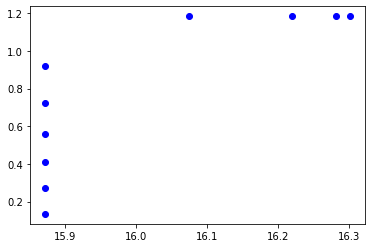

In [11]:
plt.plot(np.real(omegas),np.imag(omegas),'bo')

#### Compare the eigenvectors for the undriven viscid and inviscid solutions. They are similar, up to a complex factor.

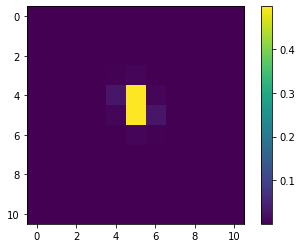

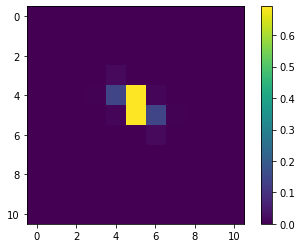

In [12]:
plt.imshow(np.abs(vns[2][2,args.Nt]).T)
plt.colorbar()
plt.show()
plt.imshow(np.abs(v0_inviscid).T)
plt.colorbar()
plt.show()

### Continue inviscid mode to the viscid one instead

In [15]:
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

In [14]:
from scipy.linalg import solve
from scipy.linalg import LinAlgWarning
import warnings
warnings.filterwarnings("error",category=LinAlgWarning)

viscid.args.freq=5
viscid.args.ad=0

F,G=viscid.inviscid_mat(args)
Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
evals,levecs,revecs=eig(Fflattened,Gflattened,left=True)

ind=np.argmin((-evals)**0.5)+1
print(ind,evals[ind])
v0_inviscid=revecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1)))
w0_inviscid=np.conjugate(levecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1))))
omega_inviscid=(-evals[ind])**0.5

args.mu=0.005
E=viscid.viscid_mat(omega_inviscid,args)

v=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
w=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
v[2,args.Nt]=v0_inviscid
w[2,args.Nt]=w0_inviscid
print(omega_inviscid,np.einsum("kKlLmMnN,KLMN,klmn",E,v,w))

0 0.05 0.1 1 20 0.005 980 2
63 (-298.9937927425745+0j)
(17.291436977376243+0j) (-0.049058451351176674-1.7727713506632088j)


In [18]:
start=timeit.default_timer()

domega=1e-1
omega=omega_inviscid
itmax=100
for i in range(itmax):
    E=viscid.viscid_mat(omega,args)
    dE=(viscid.viscid_mat(omega+domega,args)-E)/domega
    omega=omega-np.einsum("kKlLmMnN,KLMN,klmn",E,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",dE,v,w)
    flat=np.transpose(E,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
    try:
        xi=solve(flat, np.einsum("kKlLmMnN,KLMN",dE,v).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",dE,w).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        v=xi/np.linalg.norm(xi)
        w=zeta/np.linalg.norm(zeta)
    except LinAlgWarning:
        print('convergence')
        omega=omega-np.einsum("kKlLmMnN,KLMN,klmn",E,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",dE,v,w)
        e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",E,v))
        e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",E,w))
        print(e1,e2,omega,flush=True)
        break

    e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",E,v))
    e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",E,w))
    print(e1,e2,omega,flush=True)
stop=timeit.default_timer()
print(stop-start)

4.574682658493487 0.027877988104101872 (16.323792476656177+0.028195211995869274j)
2.8553231426661094 0.020004570045683786 (15.479331930622424+1.2328436780383987j)
0.12383143167113762 0.0008596369874377643 (15.442314004083395+1.183376009675183j)
0.0012197917739877975 8.519926473412771e-06 (15.442583785694245+1.1839177456193342j)
3.539329750954373e-06 2.4722231140968734e-08 (15.442582983770482+1.1839161833044662j)
convergence
1.1385720400898464e-08 2.040963932569154e-10 (15.44258298846363+1.1839161924720165j)
32.260735679999925


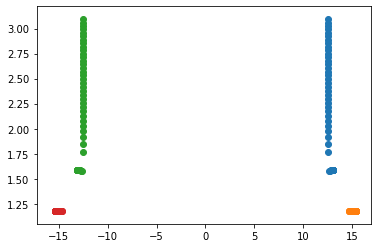

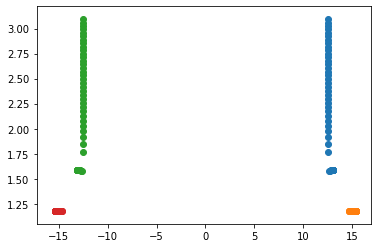

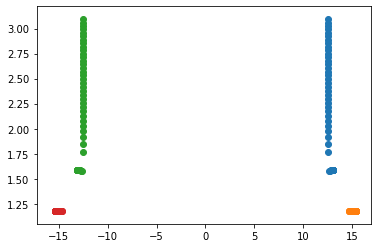

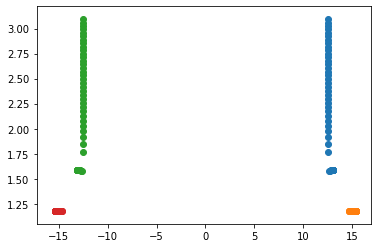

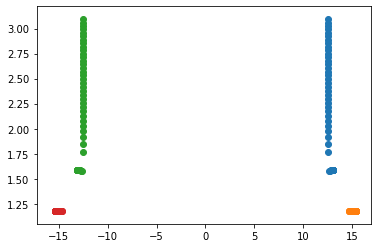

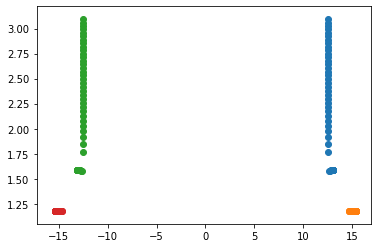

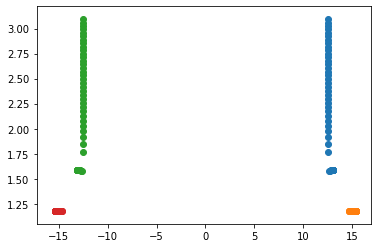

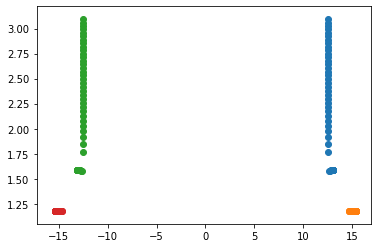

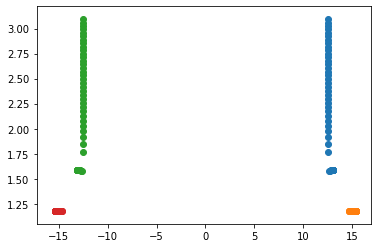

In [97]:
for i in range(1,10):
    evals0=np.load('data/mode'+str(i)+'evals_cont0.npy')
    plt.scatter(np.real(evals0),np.imag(evals0))
    evals1=np.load('data/mode'+str(i)+'evals_cont1.npy')
    plt.scatter(np.real(evals1),np.imag(evals1))
    evals2=np.load('data/mode'+str(i)+'evals_cont2.npy')
    plt.scatter(np.real(evals2),np.imag(evals2))
    evals3=np.load('data/mode'+str(i)+'evals_cont3.npy')
    plt.scatter(np.real(evals3),np.imag(evals3))
    plt.show()